In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML, SVG
from db import Result
import papermill as pm
import seaborn
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score, roc_curve, f1_score
from evaluate import calculate_confusion_matrix_stats_predictions, calculate_roc_curve, roc_auc_score
from tabulate import tabulate
from calculate_features import all_features
from config import config
from data import data

Using TensorFlow backend.


In [2]:
UUIDS = [    
    "5d1d4156-ee5a-49ff-87cf-ad4a11be8aef", # t1
    "47cf8213-5aca-4e1f-b2ba-8dbf4aac7830", # t2
    "b0fb56eb-f2fa-4a5a-bd76-297ec64a371e", # features
]
SELECTIONS = {
    # old selections
    "9adb8e80-457c-4419-8b01-92325ba99fc3": { # t1
        ("benign", "benign"): ["Kidney-Mayo-060"],
        ("benign", "malignant"): ["Kidney-HP-049"],
        ("malignant", "malignant"): ["Kidney-Penn-082"],
        ("malignant", "benign"): [],
    },
    "391b0942-7801-4184-b551-2b62fe269c58": { # t2
        ("benign", "benign"): ["Kidney-Mayo-055", "Kidney-Mayo-054"],
        ("benign", "malignant"): ["Kidney-Mayo-046", "Kidney-Penn-004"],
        ("malignant", "malignant"): ["Kidney-TCGA-034", "Kidney-Penn-108"],
        ("malignant", "benign"): ["Kidney-Penn-193", "Kidney-XY2-007"],
    },
}
TSNE_PERPLEXITY = {
    "5d1d4156-ee5a-49ff-87cf-ad4a11be8aef": 20, # t1
    "47cf8213-5aca-4e1f-b2ba-8dbf4aac7830": 5, # t2
}
MODALITY = {
    "5d1d4156-ee5a-49ff-87cf-ad4a11be8aef": "t1", # t1
    "47cf8213-5aca-4e1f-b2ba-8dbf4aac7830": "t2", # t2
    "b0fb56eb-f2fa-4a5a-bd76-297ec64a371e": "features", # features    
    # old
    "9adb8e80-457c-4419-8b01-92325ba99fc3": "t1", # t1
    "391b0942-7801-4184-b551-2b62fe269c58": "t2", # t2
    "dce56921-62a8-40f3-8cce-73b06d2b049c": "features", # features
}
SKIP = False

In [3]:
def execute_notebook(uuid, selections=None, tsne_perplexity=5, input_form="none", description=""): 
    if not SKIP: 
        pm.execute_notebook(
            "evaluate-specific-model.ipynb",
            "evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid),
            parameters = dict(
                UUID=uuid,
                SELECTIONS=repr(selections),
                TSNE_PERPLEXITY=tsne_perplexity,
            ),
    )
    return "evaluate-{}-{}-{}.ipynb".format(description, input_form, uuid)

In [4]:
completed_notebooks = list()
modality_by_notebook = dict()

In [5]:
for uuid in UUIDS: 
    print(uuid)
    result = Result.query.filter(Result.uuid == uuid).first()
    name = execute_notebook(uuid, SELECTIONS.get(uuid), TSNE_PERPLEXITY.get(uuid), result.input_form, result.description)
    completed_notebooks.append(name)
    modality_by_notebook[name] = MODALITY[uuid]
    print("done")

Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-2.5D-2-t1-5d1d4156-ee5a-49ff-87cf-ad4a11be8aef.ipynb


5d1d4156-ee5a-49ff-87cf-ad4a11be8aef


Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-2.5D-2-t2-47cf8213-5aca-4e1f-b2ba-8dbf4aac7830.ipynb


done
47cf8213-5aca-4e1f-b2ba-8dbf4aac7830


Input Notebook:  evaluate-specific-model.ipynb
Output Notebook: evaluate-2.5D-2-features-b0fb56eb-f2fa-4a5a-bd76-297ec64a371e.ipynb


done
b0fb56eb-f2fa-4a5a-bd76-297ec64a371e



done


In [6]:
if not SKIP: 
    pm.execute_notebook(
        "evaluate-ensemble.ipynb",
        "evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)),
        parameters = dict(
            MODELS=UUIDS,
        ),
    )
completed_notebooks.append("evaluate-ensemble-{}.ipynb".format("-".join(UUIDS)))


Input Notebook:  evaluate-ensemble.ipynb
Output Notebook: evaluate-ensemble-5d1d4156-ee5a-49ff-87cf-ad4a11be8aef-47cf8213-5aca-4e1f-b2ba-8dbf4aac7830-b0fb56eb-f2fa-4a5a-bd76-297ec64a371e.ipynb


In [7]:
modality_by_notebook["evaluate-ensemble-{}.ipynb".format("-".join(UUIDS))] = "ensemble"

In [8]:
def get_notebook_output(notebook, name): 
    return notebook.dataframe[notebook.dataframe.name==name].value.tolist()[0]

In [9]:
train = dict()
validation = dict()
test = dict()
for notebook in completed_notebooks: 
    nb = pm.read_notebook(notebook)
    train["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "train_labels")
    train["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "train_predictions")
    train["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "train_probabilities")
    validation["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "validation_labels")
    validation["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "validation_predictions")
    validation["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "validation_probabilities")
    test["{}-{}".format(modality_by_notebook[notebook], "labels")] = get_notebook_output(nb, "test_labels")
    test["{}-{}".format(modality_by_notebook[notebook], "predictions")] = get_notebook_output(nb, "test_predictions")
    test["{}-{}".format(modality_by_notebook[notebook], "probabilities")] = get_notebook_output(nb, "test_probabilities")

In [10]:
import uuid
result = Result.query.filter(Result.uuid == UUIDS[0]).first()
train_set, validation_set, test_set = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

 20%|█▉        | 65/332 [00:25<01:26,  3.10it/s]


################################################################################
Exception occurred for: patient    Kidney-Penn-115
volume            0.658593
outcome          malignant
age               0.594595
sex                      0
Name: Kidney-Penn-115, dtype: object
[Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-115-T1C-imagingVolume.nrrd'
Traceback (most recent call last):
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 280, in generate_from_features
    t1_masked = load_image(t1_image_file, t1_seg_file, verbose=verbose)
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 240, in load_image
    image, _ = nrrd.read(image_path)
  File "/home/user1/.local/share/virtualenvs/renal-mri-NanAjWL7/lib/python3.6/site-packages/nrrd/reader.py", line 427, in read
    with open(filename, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-115-T1C-imagingVolume

 35%|███▍      | 115/332 [00:48<02:59,  1.21it/s]


################################################################################
Exception occurred for: patient    Kidney-Penn-153
volume            0.658695
outcome          malignant
age               0.540541
sex                      1
Name: Kidney-Penn-153, dtype: object
[Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-153-T1C-imagingVolume.nrrd'
Traceback (most recent call last):
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 280, in generate_from_features
    t1_masked = load_image(t1_image_file, t1_seg_file, verbose=verbose)
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 240, in load_image
    image, _ = nrrd.read(image_path)
  File "/home/user1/.local/share/virtualenvs/renal-mri-NanAjWL7/lib/python3.6/site-packages/nrrd/reader.py", line 427, in read
    with open(filename, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-153-T1C-imagingVolume

 47%|████▋     | 157/332 [01:03<00:54,  3.22it/s]


################################################################################
Exception occurred for: patient    Kidney-Penn-266
volume            0.658453
outcome          malignant
age               0.567568
sex                      1
Name: Kidney-Penn-266, dtype: object
[Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-266-T1C-imagingVolume.nrrd'
Traceback (most recent call last):
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 280, in generate_from_features
    t1_masked = load_image(t1_image_file, t1_seg_file, verbose=verbose)
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 240, in load_image
    image, _ = nrrd.read(image_path)
  File "/home/user1/.local/share/virtualenvs/renal-mri-NanAjWL7/lib/python3.6/site-packages/nrrd/reader.py", line 427, in read
    with open(filename, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-266-T1C-imagingVolume

 92%|█████████▏| 305/332 [01:58<00:13,  2.00it/s]


################################################################################
Exception occurred for: patient    Kidney-Penn-080
volume            0.660122
outcome             benign
age               0.756757
sex                      1
Name: Kidney-Penn-080, dtype: object
[Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-080-T1C-imagingVolume.nrrd'
Traceback (most recent call last):
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 280, in generate_from_features
    t1_masked = load_image(t1_image_file, t1_seg_file, verbose=verbose)
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 240, in load_image
    image, _ = nrrd.read(image_path)
  File "/home/user1/.local/share/virtualenvs/renal-mri-NanAjWL7/lib/python3.6/site-packages/nrrd/reader.py", line 427, in read
    with open(filename, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-080-T1C-imagingVolume

 56%|█████▋    | 53/94 [00:18<00:09,  4.44it/s]


################################################################################
Exception occurred for: patient    Kidney-Penn-029
volume            0.658486
outcome          malignant
age               0.581081
sex                      1
Name: Kidney-Penn-029, dtype: object
[Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-029-T1C-imagingVolume.nrrd'
Traceback (most recent call last):
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 280, in generate_from_features
    t1_masked = load_image(t1_image_file, t1_seg_file, verbose=verbose)
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 240, in load_image
    image, _ = nrrd.read(image_path)
  File "/home/user1/.local/share/virtualenvs/renal-mri-NanAjWL7/lib/python3.6/site-packages/nrrd/reader.py", line 427, in read
    with open(filename, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-029-T1C-imagingVolume

 80%|███████▉  | 75/94 [00:28<00:13,  1.41it/s]


################################################################################
Exception occurred for: patient    Kidney-Penn-007
volume            0.658458
outcome             benign
age               0.635135
sex                      1
Name: Kidney-Penn-007, dtype: object
[Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-007-T1C-imagingVolume.nrrd'
Traceback (most recent call last):
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 280, in generate_from_features
    t1_masked = load_image(t1_image_file, t1_seg_file, verbose=verbose)
  File "/home/user1/intrepidlemon/renal-mri/data.py", line 240, in load_image
    image, _ = nrrd.read(image_path)
  File "/home/user1/.local/share/virtualenvs/renal-mri-NanAjWL7/lib/python3.6/site-packages/nrrd/reader.py", line 427, in read
    with open(filename, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: '/data/intrepidlemon/renal/preprocessed/Kidney-Penn-007-T1C-imagingVolume

100%|██████████| 47/47 [00:14<00:00,  4.74it/s]


In [11]:
MODALITIES = [
    "features",     
    "t1", 
    "t2", 
    "ensemble", 
]

def get_pr_data_for_modality(dataset): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        print(modality, len(labels), len(probabilities), len(predictions))
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f})".format(modality, pr_auc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f})".format(modality, pr_auc)})
    return results, pr_auc, []
        
def plot_multiple_precision_recall(dataset, experts=[]):
    results, auc, points = get_pr_data_for_modality(dataset)        
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            points.append({
                "precision": stats["PPV"][1],
                "recall": stats["TPR"][1],                
                "experts": "Expert {}".format(i + 1), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="recall",
        y="precision",
        hue="modality",
        ax=ax, 
        err_style=None,
    )
    if points: 
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="recall",
            y="precision",
            hue="experts",
            style="experts",                        
            markers={ "Expert 1": "o", "Expert 2": "v", "Expert 3": "s", "Expert 4": "P"},            
            palette={ "Expert 1": "black", "Expert 2": "black", "Expert 3": "black", "Expert 4": "black" },
            ax=ax,
        )
    ax.set_ylim(0.5, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_roc_data_for_modality(dataset): 
    results = list()
    points = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f})".format(modality, roc_auc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f})".format(modality, roc_auc)})
    return results, roc_auc, []
        
def plot_multiple_roc_curve(dataset, experts=[]):
    results, auc, points = get_roc_data_for_modality(dataset)
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = dataset["t1-labels"]
            predictions = expert
            stats = calculate_confusion_matrix_stats_predictions(labels, predictions)
            points.append({
                "fpr": stats["FPR"][1],
                "tpr": stats["TPR"][1],
                "experts": "Expert {}".format(i + 1), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="fpr",
        y="tpr",
        hue="modality",
        ax=ax,
        err_style=None,
    )
    if points:     
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="fpr",
            y="tpr",
            hue="experts",
            style="experts",            
            ax=ax,
            markers={ "Expert 1": "o", "Expert 2": "v", "Expert 3": "s", "Expert 4": "P"},            
            palette={ "Expert 1": "black", "Expert 2": "black", "Expert 3": "black", "Expert 4": "black" },
        )
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_statistics(dataset, experts=[]): 
    results = list()
    for modality in MODALITIES: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        d = {
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats_predictions(labels, predictions), 
            "Modality": [modality.capitalize(), modality.capitalize()], 
        } 
        # remove more that are not relevant to imbalanced datasets
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]
        del d["TPR"]
        del d["TNR"]        
        del d["FPR"]
        del d["FNR"]        
        results.append(pandas.DataFrame(d).iloc[[1]])
    for i, expert in enumerate(experts): 
        labels = dataset["t1-labels"]
        predictions = expert
        f1 = f1_score(labels, predictions)        
        d = {
            "F1 Score": [f1, f1],            
            **calculate_confusion_matrix_stats_predictions(labels, predictions),             
            "Modality": ["Expert {}".format(i + 1), "Expert {}".format(i + 1)], 
        }
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]         
        del d["TPR"]
        del d["TNR"]                
        del d["FPR"]
        del d["FNR"]        
        results.append(pandas.DataFrame(d).iloc[[1]])
    return pandas.concat(results, axis=0, sort=False).set_index("Modality")

def get_experts_for_names(features, names, experts=["expert1", "expert2"]): 
    result = list()
    for e in experts: 
        expert_results = list()
        for n in names: 
            f = features.get(n, None)
            if f is None: 
                print("error, cannot find {}".format(n))
                expert_results.append(-1)
                continue
            expert_results.append(int(f.get(e, -1)))
        result.append(expert_results)
    return result

In [12]:
expert_features = all_features(files = [config.EXPERTS])
df = get_statistics(train, get_experts_for_names(expert_features, train_set.names))
print()
print("##### Train")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics(validation, get_experts_for_names(expert_features, validation_set.names))
print()
print("##### Validation")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))
df = get_statistics(test, get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))
print()
print("##### Test")
print()
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.3g").replace("nan", "N/A").replace("Features", "Clinical"))


##### Train

| Modality   |   F1 Score |   ROC AUC |   PR AUC |   Acc |   PPV |   NPV |    FDR |    AM |    GM |
|:-----------|-----------:|----------:|---------:|------:|------:|------:|-------:|------:|------:|
| Clinical   |      0.727 |     0.476 |    0.751 | 0.613 | 0.812 | 0.267 | 0.188  | 0.554 | 0.544 |
| T1         |      0.929 |     0.911 |    0.970 | 0.884 | 0.898 | 0.811 | 0.102  | 0.783 | 0.763 |
| T2         |      0.913 |     0.872 |    0.947 | 0.854 | 0.857 | 0.829 | 0.143  | 0.693 | 0.632 |
| Ensemble   |      0.979 |     0.993 |    0.998 | 0.966 | 0.962 | 0.984 | 0.0376 | 0.928 | 0.925 |
| Expert 1   |      0.877 |   N/A     |  N/A     | 0.793 | 0.820 | 0.545 | 0.180  | 0.598 | 0.489 |
| Expert 2   |      0.894 |   N/A     |  N/A     | 0.820 | 0.830 | 0.714 | 0.170  | 0.625 | 0.522 |

##### Validation

| Modality   |   F1 Score |   ROC AUC |   PR AUC |   Acc |   PPV |   NPV |   FDR |    AM |    GM |
|:-----------|-----------:|----------:|---------:|------:|------:|--

features 328 328 328
t1 328 328 328
t2 328 328 328
ensemble 328 328 328


/home/user1/.local/share/virtualenvs/renal-mri-NanAjWL7/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


features 92 92 92
t1 92 92 92
t2 92 92 92
ensemble 92 92 92
features 47 47 47
t1 47 47 47
t2 47 47 47
ensemble 47 47 47


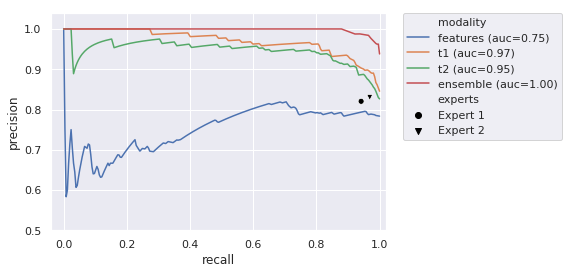

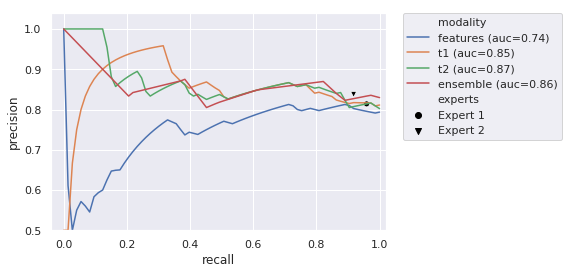

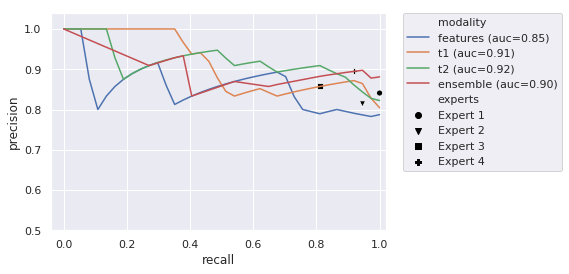

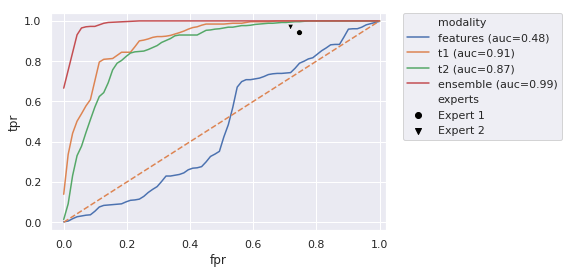

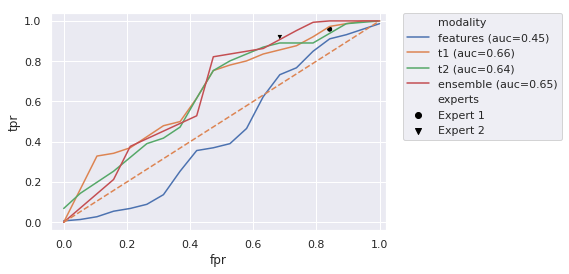

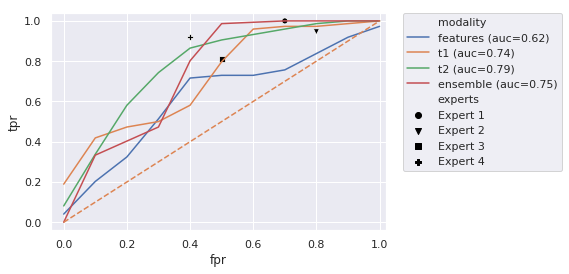

In [13]:
fig = plot_multiple_precision_recall(train, experts=get_experts_for_names(expert_features, train_set.names))
fig.savefig("figures/combined-train-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_precision_recall(validation, experts=get_experts_for_names(expert_features, validation_set.names))
fig.savefig("figures/combined-validation-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_precision_recall(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))
fig.savefig("figures/combined-test-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(train, experts=get_experts_for_names(expert_features, train_set.names))
fig.savefig("figures/combined-train-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(validation, experts=get_experts_for_names(expert_features, validation_set.names))
fig.savefig("figures/combined-validation-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(test, experts=get_experts_for_names(expert_features, test_set.names, experts=["expert1", "expert2", "expert3", "expert4"]))
fig.savefig("figures/combined-test-roc.svg", bbox_inches = "tight")

In [14]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')